Copyright (c) 2020 Joel BASSA
<br/>
**Objectif:** ce projet a pour objectif de mettre en oeuvre un modèle d'apprentissage supervisé pour la prédiction des retards à l'arrivée des vols en direction de l'aéroport de **BOS** .

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 0 - Chargement des bibliothèques

In [2]:
# Manipulation de données
import numpy as np
import pandas as pd

# Visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers
from helpers import polynomial

# Outils divers
from tqdm import tqdm
from collections import defaultdict

# Machine Learning

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Configuration de la visualisation
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## 1 - Lecture du jeu de données

In [4]:
#Sélection des variables par intuition
cols_train = ['dep_delay','arr_delay','distance','wind_dir','wind_speed','week_day','evening_rush_hour','precip_indic']
cols_test = cols_train.copy()
cols_test.remove('arr_delay')

BOS_TRAIN = pd.read_csv('data/BOS_train.csv', usecols=cols_train)
BOS_TEST = pd.read_csv('data/BOS_test.csv', index_col=[0])
BOS_TEST = BOS_TEST[cols_test]

<strong style="color: #4a86e8">Quelques lignes de notre jeu de données</strong>

In [5]:
BOS_TRAIN.head()

,dep_delay,arr_delay,distance,wind_dir,wind_speed,week_day,evening_rush_hour,precip_indic
0,1,-20,200,140,4.60312,Monday,False,False
1,60,121,200,140,6.90468,Monday,False,False
2,-10,-8,200,140,6.90468,Monday,False,False
3,9,-2,200,150,3.45234,Monday,False,False
4,6,0,200,110,8.05546,Monday,False,True


In [6]:
BOS_TEST.head()

,dep_delay,distance,wind_dir,wind_speed,week_day,evening_rush_hour,precip_indic
1345,-11,184,270,11.50780,Monday,False,False
118,198,200,240,12.65858,Monday,False,False
1212,9,184,300,5.75390,Thursday,True,False
409,-4,200,230,5.75390,Saturday,False,False
284,8,200,240,10.35702,Friday,False,False


In [7]:
print(BOS_TRAIN.shape)
print(BOS_TEST.shape)

(824, 8)
(205, 7)


## 2 - Visualisation des données

Quelques visualisations afin de comprendre la rélation entre certaines variables et le rétard à l'arrivée.

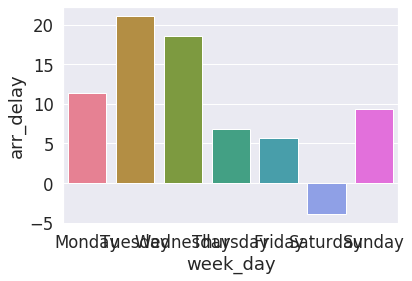

In [8]:
ax = sns.barplot(x="week_day", y="arr_delay", data=BOS_TRAIN, palette="husl", ci=None)

## 3 - Préparation de données

<strong style="color: #4a86e8">Valeurs nulles dans le jeu de données?</strong>

In [9]:
print(BOS_TRAIN.isnull().values.any())
print(BOS_TEST.isnull().values.any())

False
False


<strong style="color: #4a86e8">Type des variables</strong>

In [10]:
BOS_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 8 columns):
dep_delay            824 non-null int64
arr_delay            824 non-null int64
distance             824 non-null int64
wind_dir             824 non-null int64
wind_speed           824 non-null float64
week_day             824 non-null object
evening_rush_hour    824 non-null bool
precip_indic         824 non-null bool
dtypes: bool(2), float64(1), int64(4), object(1)
memory usage: 40.4+ KB


In [11]:
BOS_TEST.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 1345 to 448
Data columns (total 7 columns):
dep_delay            205 non-null int64
distance             205 non-null int64
wind_dir             205 non-null int64
wind_speed           205 non-null float64
week_day             205 non-null object
evening_rush_hour    205 non-null bool
precip_indic         205 non-null bool
dtypes: bool(2), float64(1), int64(3), object(1)
memory usage: 10.0+ KB


Etant donné la présence de variables qualitatives, nous allons appliquer des transformations afin de les rendre quantitatives.

In [12]:
#Encodage binaire
BOS_TRAIN.evening_rush_hour = BOS_TRAIN['evening_rush_hour'].astype(int)
BOS_TEST.evening_rush_hour = BOS_TEST['evening_rush_hour'].astype(int)

BOS_TRAIN.precip_indic = BOS_TRAIN['precip_indic'].astype(int)
BOS_TEST.precip_indic = BOS_TEST['precip_indic'].astype(int)

#Encodage ordonné
days = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4 , 'Friday':5, 'Saturday':6, 'Sunday':7}
BOS_TRAIN['week_day'] = BOS_TRAIN['week_day'].apply(lambda x: days[x] if x in days else x)
BOS_TEST['week_day'] = BOS_TEST['week_day'].apply(lambda x: days[x] if x in days else x)


<strong style="color: #4a86e8">Mise à l'échelle</strong>

Afin de faciliter les calculs pour les algorithmes , nous allons faire une mise à l'échelle de certaines de nos variables

In [13]:
BOS_TRAIN.wind_speed = BOS_TRAIN.wind_speed / 100
BOS_TEST.wind_speed = BOS_TEST.wind_speed / 100
BOS_TRAIN.distance = BOS_TRAIN.distance / 100
BOS_TEST.distance = BOS_TEST.distance / 100

Il faudrait vérifier si les transformations ont éte bien effectuées

In [14]:
BOS_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 8 columns):
dep_delay            824 non-null int64
arr_delay            824 non-null int64
distance             824 non-null float64
wind_dir             824 non-null int64
wind_speed           824 non-null float64
week_day             824 non-null int64
evening_rush_hour    824 non-null int64
precip_indic         824 non-null int64
dtypes: float64(2), int64(6)
memory usage: 51.6 KB


In [15]:
BOS_TRAIN.head()

,dep_delay,arr_delay,distance,wind_dir,wind_speed,week_day,evening_rush_hour,precip_indic
0,1,-20,2.0,140,0.046031,1,0,0
1,60,121,2.0,140,0.069047,1,0,0
2,-10,-8,2.0,140,0.069047,1,0,0
3,9,-2,2.0,150,0.034523,1,0,0
4,6,0,2.0,110,0.080555,1,0,1


## 4 - Entrainement

Pour le jeu d'entrainement , nous allons séparer les prédicteurs de la variable réponse

In [16]:
X = BOS_TRAIN[cols_test].values
y = BOS_TRAIN['arr_delay'].values.reshape(-1,1)
print(X.shape)
print(y.shape)

(824, 7)
(824, 1)


<strong style="color: #4a86e8">Séparons les données en jeu d'entraînement et jeu de test. La taille du jeu de test doit représenter 30% de la taille du jeu de données et l'état du générateur aléatoire sera fixé à 2020 afin de permettre la reproductibilité</strong>

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2020)

### Tentons une régression linéaire d'ordre 1 seulement

Instanciation de `scaler` pour la standardisation des données

In [18]:
scaler = StandardScaler()

In [19]:
# Pseudo code:
# ------------
#
# Instancier KFold (sklearn)
#
# Standardiser X
#
# Itérer sur les k plis:
#     Effectuer la régression sur le plis courant (jeu d'entraînement)
#     Évaluer les performances sur le jeu de validation

history = defaultdict(list)

kf = KFold(n_splits = 5)

# Standardisation
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

for train_index, val_index in kf.split(X_train_scaled):
    # Préparation des plis
    x_cv_train, x_cv_val = X_train_scaled[train_index,:], X_train_scaled[val_index,:]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
    
    # Régression linéaire
    reg = LinearRegression().fit(x_cv_train, y_cv_train)
    
    # Record performances par plis
    history['train'].append(reg.score(x_cv_train, y_cv_train))
    history['val'].append(reg.score(x_cv_val, y_cv_val))
        
print(f"RSquared de validation = {np.mean(history['val'])}")
print(f"Rsquared d'entraînement = {np.mean(history['train'])}")

RSquared de validation = 0.8960981570054086
Rsquared d'entraînement = 0.9018482199147932


### Entrainement du  modèle (Régression linéaire)

Réentrainons le modèle de régression sur l'ensemble des données d'entraînement

In [20]:
# Standardisation
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

reg_best = LinearRegression().fit(X_train_scaled, y_train)
X_train_scaled.shape

(576, 7)

### Performances du modèle (Régression linéaire) sur le jeu de test

In [21]:
# Standardisation
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

In [22]:
reg_best.score(X_test_scaled, y_test)

0.887615638049632

### Effectuons une validation croisée à 5 plis sur une régression KNN en faisant varier le nombre de voisins de 1 à 20

In [23]:
def KNeighborsRegressorCV(k):
    history = defaultdict(list)
    
    kf = KFold(n_splits=5)

    for train_index, val_index in kf.split(X_train):
        x_cv_train, x_cv_val = X_train[train_index,:], X_train[val_index,:]
        y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]

        # Regression KNN
        neigh = KNeighborsRegressor(n_neighbors=k).fit(x_cv_train, y_cv_train)
    
        # Record performances par plis
        history['train'].append(neigh.score(x_cv_train, y_cv_train))
        history['val'].append(neigh.score(x_cv_val, y_cv_val))
        
    return np.mean(history['train']), np.mean(history['val'])

    
history = defaultdict(list)
for k in range(1, 20):
    t, v = KNeighborsRegressorCV(k)
    history['train'].append(t)
    history['val'].append(v)

### Choix du meilleur modèle en fonction des performances sur les plis de validation

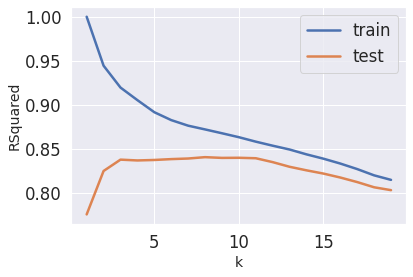

In [24]:
f, ax = plt.subplots(1,1)
ax.plot(range(1, 20), history['train'], label="train")
ax.plot(range(1, 20), history['val'], label="test")
ax.set_xlabel('k', fontsize=14)
ax.set_ylabel('RSquared', fontsize=14)
ax.legend()

### Entrainement du meilleur modèle (KNN)

Réentrainons le modèle de régression sur l'ensemble des données d'entraînement

In [25]:
neigh_best = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)

### Performances du meilleur modèle (KNN)

In [26]:
neigh_best.score(X_test, y_test)

0.8446334498458044

Après la mise en oeuvre de ces deux modèles (régression linéaire et KNN), la performance du modèle de regression semble mieux en théorie. Cependant nous irons de l'avant avec le KNN qui est un modèle plus complexe que la régression linéaire.


### Performances du meilleur modèle (KNN) sur le jeu de test

In [27]:
y_pred_test = neigh_best.predict(BOS_TEST)
BOS_TEST['y_pred_test'] = y_pred_test
BOS_TEST.to_csv('output.csv', columns=['y_pred_test'])

### Fin du projet